## **Pipeline de um modelo linear de classificação de sonegação fiscal – Estudo com Dados Sintéticos**



### **Definição do Objetivo:**

Este projeto tem como objetivo avaliar a viabilidade de um modelo linear de machine learning, o de `Regressão Logística`, para identificar padrões fiscais associados à sonegação de impostos. Trata-se de um estudo, com dados sintéticos, que busca entender limitações e oportunidades para futuras aplicações práticas e reais utilizando modelos preditivos na detecção desses casos em prol de uma análise tributária mais estratégica.

Os dados utilizando foram gerados com o auxílio do modelo GPT-4o, representando a realidade tributária de empresas do Espírito Santo e podem ser acessados através do arquivo `dataset_fiscal.xlsx` contido no repositório.

### **Importação dos pacotes a serem utilizados**

In [42]:
# Instala a biblioteca que irá auxiliar a criaçao dos gráficos estatísticos.
%pip install seaborn 
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Abaixo estão listadas as bibliotecas utilizadas para manipulação dos dados, criação de visualizações e treinamento dos modelos de machine learning. A regressão logística será o modelo principal, com suporte de outras bibliotecas para análise estatística e visual.

In [43]:

# Import para manipulação dos dados tabulares
import pandas as pd

# Imports para treinar o modelo
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Imports para traçar e avaliar métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from scipy.stats import pointbiserialr

# Import para criação dos gráficos
import seaborn as sns                # Lib mais eficiente para plotagem dos histogramas.

import matplotlib.pyplot as plt             # Lib nativa para criação de gráficos.
import math                          # Lib para operações matemáticas

# Import de outras libs
from datetime import datetime, date

### **Importação dos dados**

O conjunto de dados foi gerado de forma sintética e está armazenado no arquivo `dataset_fiscal.xlsx` com 6 abas, das quais utilizaremos 4:

- **dados_cadastrais**: informações estruturais das empresas, como CNPJ, capital social e data de abertura.
- **comportamento_fiscal**: variáveis quantitativas relacionadas à emissão de notas e recolhimento de ICMS.
- **regularidade_fiscal**: atributos binários ou categóricos que indicam a situação fiscal da empresa.
- **indicadores_de_risco**: variável calculada a partir de análises tributárias e operacionais.

Essas abas foram carregadas para o ambiente com `pandas.read_excel` e separadas em dataframes individuais para facilitar a manipulação e análise posterior.

In [44]:
# Importação dos dados

lista_abas = pd.read_excel('dataset_fiscal.xlsx', sheet_name=None)  # O dataset é composto por 6 abas mas apenas 4 delas serão utilizadas.

# Separação das abas:
df_dados_cadastrais = lista_abas['dados_cadastrais']
df_comportamento_fiscal = lista_abas['comportamento_fiscal']
df_regularidade_fiscal = lista_abas['regularidade_fiscal']
df_indicadores_de_risco = lista_abas['indicadores_de_risco']

### **Análise Exploratória**

A análise exploratória é uma etapa essencial no processo de criação e treinamento do modelo, pois, através dela, podemos tomar conhecimento a respeito do comportamento dos dados contidos no dataset.

#### **Aba Dados Cadastrais**



In [45]:
# Análise exploratória - Dados Cadastrais

# Tipos dos dados
print('Tipos dos dados da aba Dados Cadastrais')
for coluna in df_dados_cadastrais.keys():
    print(f'{coluna} - ',df_dados_cadastrais[coluna].dtype)

# Verifica dados faltantes 
print()
print('Dados faltantes por coluna - Dados Cadastrias')
for coluna in df_dados_cadastrais.keys():
    print(f'{coluna} - ',df_dados_cadastrais[coluna].isnull().sum())

# Verifica a quantidade de valores únicos para as colunas do tipo objeto, com exceção do indice.
print()
print('Valores únicos categóricos - Dados Cadastrais')
for coluna in df_dados_cadastrais.keys()[1:]:
    if df_dados_cadastrais[coluna].dtype == 'object':
        print(f'{coluna} - ', df_dados_cadastrais[coluna].nunique())

Tipos dos dados da aba Dados Cadastrais
CNPJ -  object
Data_abertura -  datetime64[ns]
CNAE_principal -  object
Capital_social -  float64
Regime_tributário -  object
Município -  object
Número_funcionários -  int64

Dados faltantes por coluna - Dados Cadastrias
CNPJ -  0
Data_abertura -  0
CNAE_principal -  0
Capital_social -  0
Regime_tributário -  0
Município -  0
Número_funcionários -  0

Valores únicos categóricos - Dados Cadastrais
CNAE_principal -  5
Regime_tributário -  3
Município -  5


A partir dessa análise exploratória inicial, podemos verificar que não há dados faltantes e que existem 3 tipos de variáveis categóricas CNAE_principal, Regime_tributário e Município. Agora, iremos explorar um pouco mais dessas variáveis categóricas para entender como elas estão distribuídas ao longo do espaço amostral.

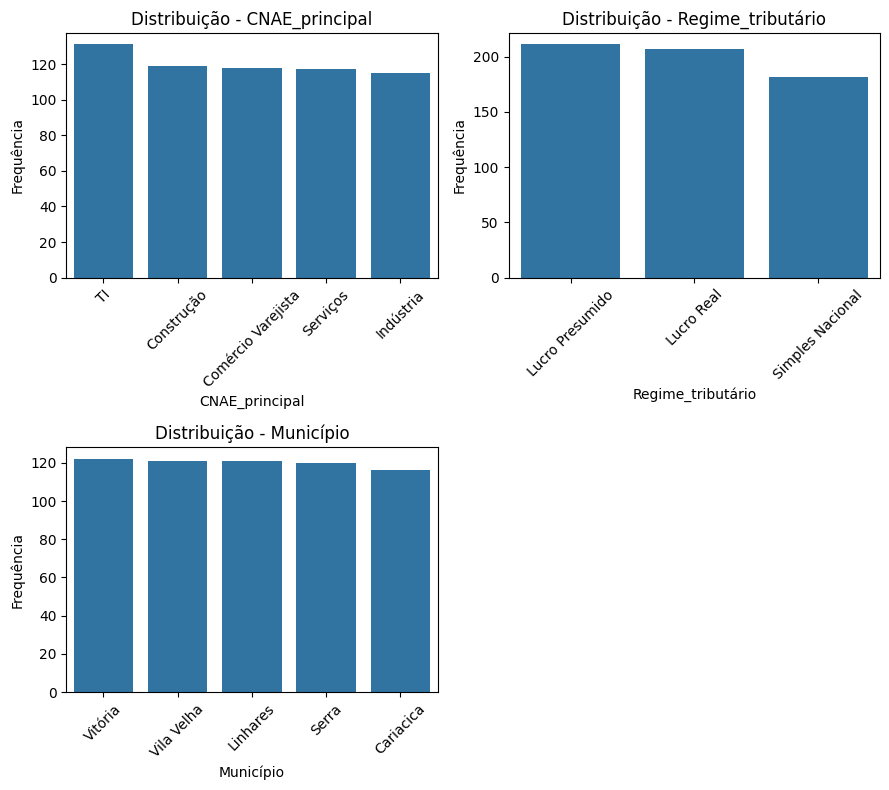

In [46]:
# Explorando as variáveis categóricas
var_cat_dados_cadastrais = []

for coluna in df_dados_cadastrais.keys()[1:]:
    if df_dados_cadastrais[coluna].dtype == 'object':
        var_cat_dados_cadastrais.append(coluna)


# Plotando os gráficos:
plt.figure(figsize=(9, 8))
for i, coluna in enumerate(var_cat_dados_cadastrais, 1):
    plt.subplot(2, 2, i)  # 2x2 para 4 gráficos
    ordem = df_dados_cadastrais[coluna].value_counts().index
    sns.countplot(data=df_dados_cadastrais, x=coluna, order=ordem)
    plt.title(f'Distribuição - {coluna}')
    plt.xticks(rotation=45)
    plt.ylabel('Frequência')
    plt.xlabel(coluna)

plt.tight_layout()
plt.show()


A analise exploratória nos mostra que os dados utilizados representam bem o cenário empresarial do Espírito Santo. Todas as categorias estão muito bem equilibradas o que ajuda na capacidade do modelo de generalizar os casos.



#### **Aba Comportamento Fiscal**


Nesta seção, foram plotadas distribuições das principais variáveis quantitativas relacionadas ao comportamento fiscal das empresas. 

In [47]:
# Análise exploratória - Comportamento Fiscal

# Tipos dos dados
print('Tipos dos dados da aba Comportamento Fiscal')
for coluna in df_comportamento_fiscal.keys():
    print(f'{coluna} - ',df_comportamento_fiscal[coluna].dtype)

# Verifica dados faltantes 
print()
print('Dados faltantes por coluna - Comportamento Fiscal')
for coluna in df_comportamento_fiscal.keys():
    print(f'{coluna} - ', df_comportamento_fiscal[coluna].isnull().sum())


Tipos dos dados da aba Comportamento Fiscal
CNPJ -  object
Valor_ICMS_pago_mensal -  float64
Valor_total_notas_emitidas -  float64
Quantidade_notas_emitidas -  int64
Percentual_notas_canceladas -  float64
Quantidade_notas_para_mesmo_CNPJ -  int64
Variação_mensal_faturamento -  float64
Valor_notas_sem_recolhimento_ICMS -  float64

Dados faltantes por coluna - Comportamento Fiscal
CNPJ -  0
Valor_ICMS_pago_mensal -  0
Valor_total_notas_emitidas -  0
Quantidade_notas_emitidas -  0
Percentual_notas_canceladas -  0
Quantidade_notas_para_mesmo_CNPJ -  0
Variação_mensal_faturamento -  0
Valor_notas_sem_recolhimento_ICMS -  0


A análise do comportamento fiscal é fundamental para identificar indícios de sonegação. Nesta etapa, explorei variáveis como o volume de notas emitidas, o valor do ICMS recolhido e a frequência de notas sem recolhimento, todas potencialmente reveladoras de padrões anômalos.

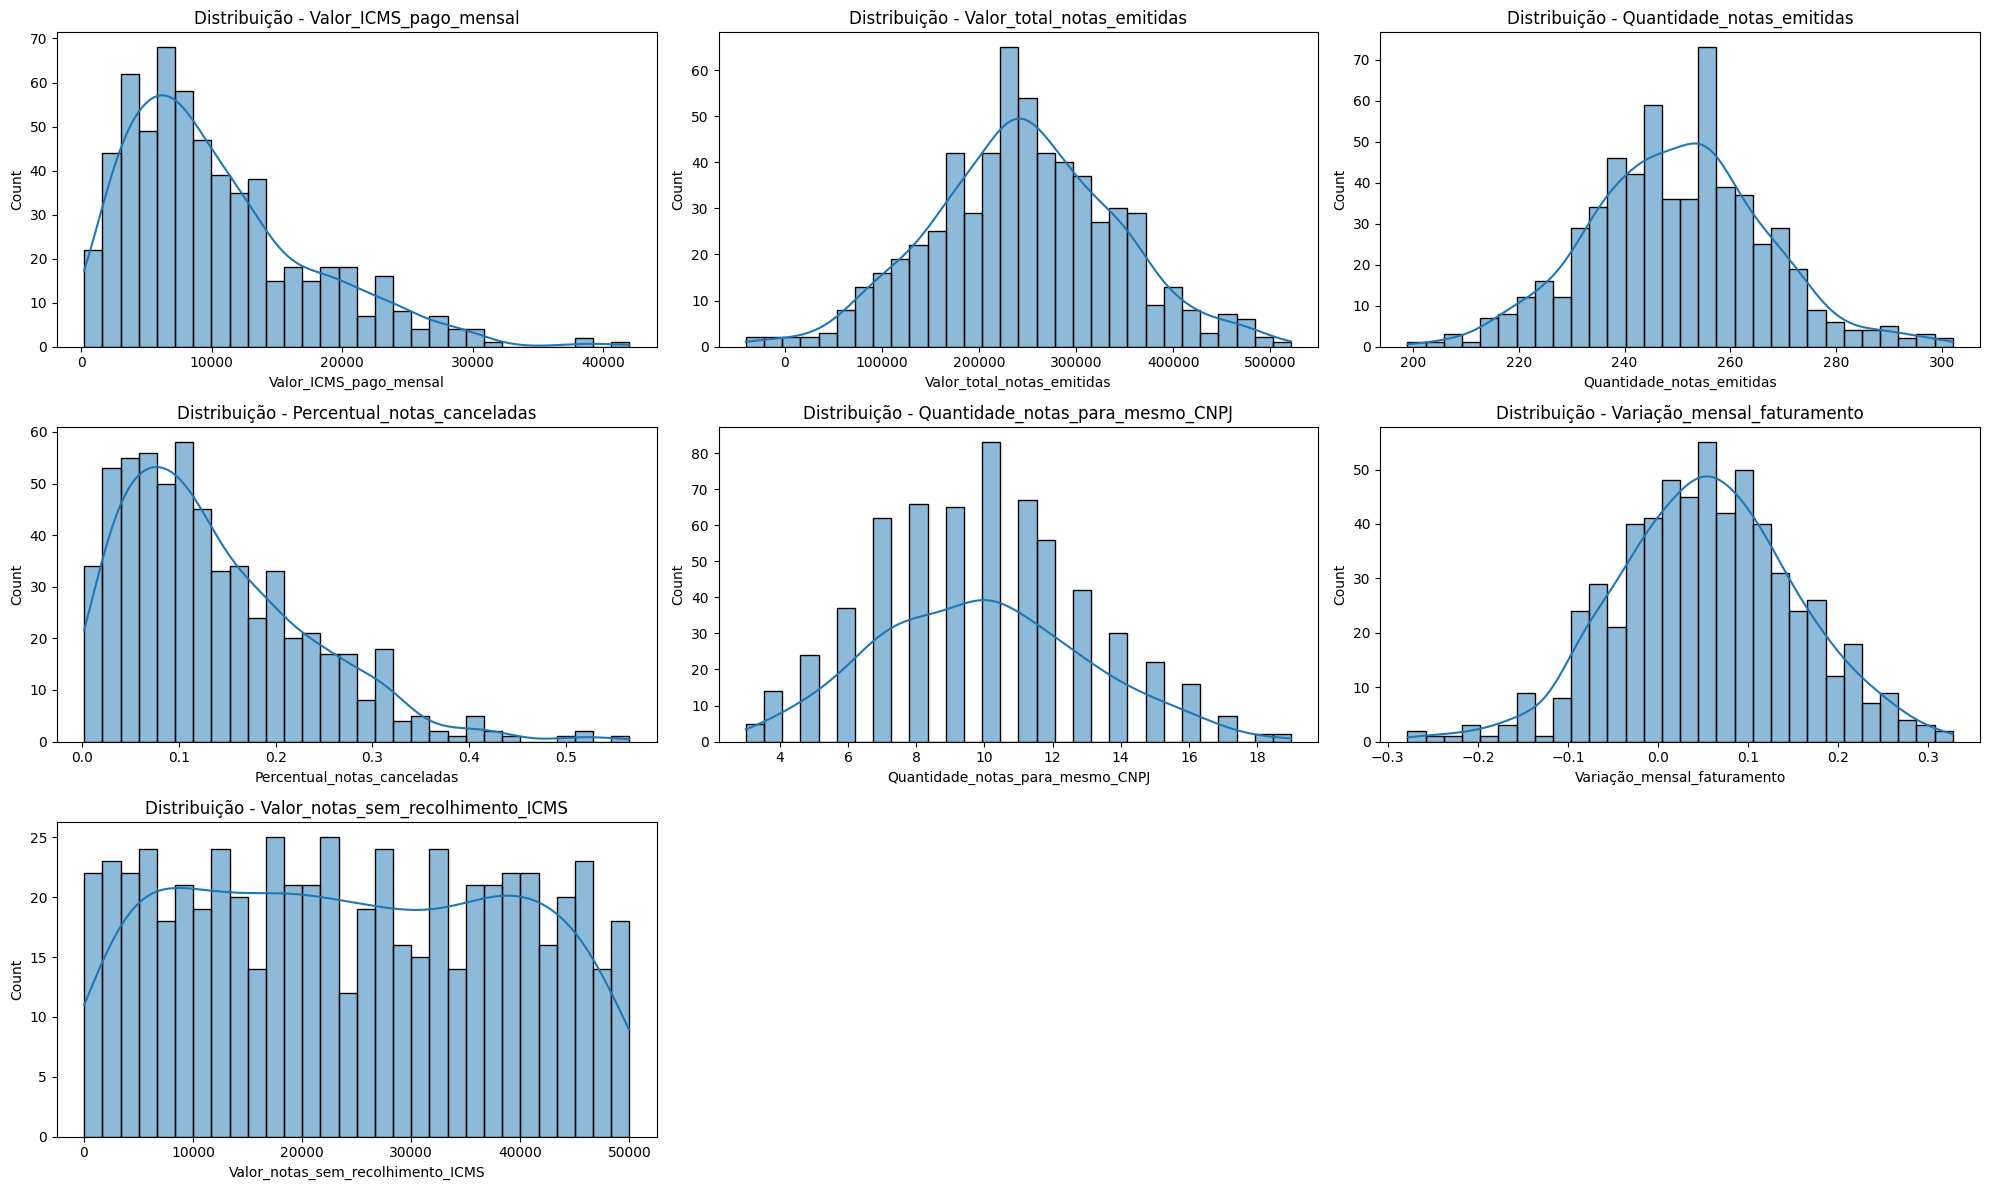

In [48]:
colunas = [
    'Valor_ICMS_pago_mensal', 'Valor_total_notas_emitidas',
    'Quantidade_notas_emitidas', 'Percentual_notas_canceladas',
    'Quantidade_notas_para_mesmo_CNPJ', 'Variação_mensal_faturamento',
    'Valor_notas_sem_recolhimento_ICMS'
]

plt.figure(figsize=(20, 12))
for i, col in enumerate(colunas, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_comportamento_fiscal[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribuição - {col}')
plt.tight_layout()
plt.show()

A partir dos histogramas é possível concluir o seguinte:

- Algumas variáveis, como `Valor_total_notas_emitidas` e `Valor_ICMS_pago_mensal`, apresentam distribuição assimétrica à direita, indicando a presença de **outliers**.
- A variável `Percentual_notas_canceladas` tende a se concentrar abaixo de 20%, mas há casos extremos.
- A `Quantidade_notas_para_mesmo_CNPJ` possui forte inclinação à esquerda, o que pode indicar **comportamento atípico** em poucas empresas.
- A `Variação_mensal_faturamento` tem distribuição mais centralizada, mas com cauda larga.

Esses insights iniciais já sugerem a necessidade de técnicas robustas de normalização para o pré-processamento dos dados.

#### **Aba Regularidade Fiscal**

In [49]:
# Análise exploratória - Regularidade Fiscal

# Tipos dos dados
print('Tipos dos dados da aba Regularidade Fiscal')
for coluna in df_regularidade_fiscal.keys():
    print(f'{coluna} - ',df_regularidade_fiscal[coluna].dtype)

# Verifica dados faltantes 
print()
print('Dados faltantes por coluna - Regularidade Fiscal')
for coluna in df_regularidade_fiscal.keys():
    print(f'{coluna} - ', df_regularidade_fiscal[coluna].isnull().sum())

# Verifica a quantidade de valores únicos para as colunas do tipo objeto, com exceção do indice.
print()
print('Valores únicos categóricos - Regularidade fiscal')
for coluna in df_regularidade_fiscal.keys()[1:]:
    if df_regularidade_fiscal[coluna].dtype == 'object':
        print(f'{coluna} - ', df_regularidade_fiscal[coluna].nunique())


Tipos dos dados da aba Regularidade Fiscal
CNPJ -  object
Quantidade_entregas_SPED_ano -  int64
Quantidade_autuações_fiscais -  int64
Valor_total_autuações -  float64
Situação_fiscal -  object
Atrasos_pagamento_tributos -  int64
Possui_parcelamento_ativo -  int64

Dados faltantes por coluna - Regularidade Fiscal
CNPJ -  0
Quantidade_entregas_SPED_ano -  0
Quantidade_autuações_fiscais -  0
Valor_total_autuações -  0
Situação_fiscal -  0
Atrasos_pagamento_tributos -  0
Possui_parcelamento_ativo -  0

Valores únicos categóricos - Regularidade fiscal
Situação_fiscal -  3


A situação fiscal declarada pode funcionar como um forte indicador de risco. A análise a seguir examina como diferentes categorias de regularidade (como inadimplência ou existência de parcelamentos ativos) se distribuem entre as empresas.

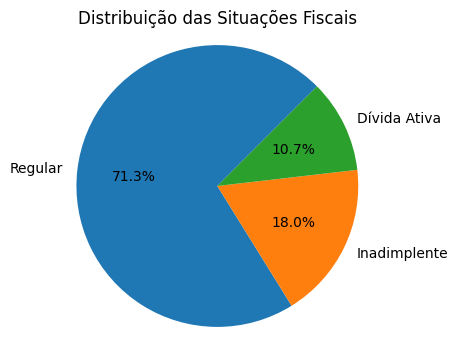

In [50]:
# Situação Fiscal
# Contagem das categorias
contagem = df_regularidade_fiscal['Situação_fiscal'].value_counts()
labels = contagem.index
sizes = contagem.values

# Criar gráfico de pizza com porcentagens
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45)
plt.title('Distribuição das Situações Fiscais')
plt.axis('equal')  
plt.show()

A maioria das empresas apresenta situação fiscal **regular**, mas há uma proporção não desprezível de empresas com pendências ou irregularidades.

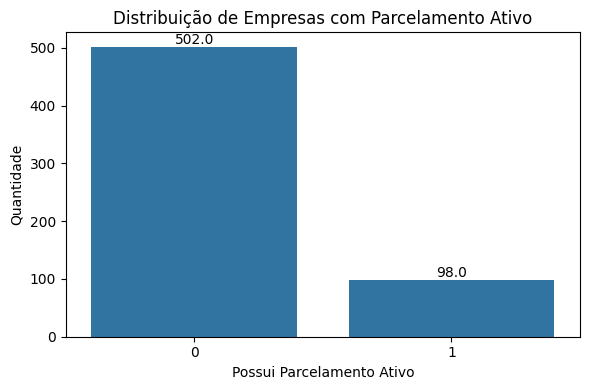

In [51]:
# Gráfico de barras com anotações
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_regularidade_fiscal, x='Possui_parcelamento_ativo')
plt.title('Distribuição de Empresas com Parcelamento Ativo')
plt.xlabel('Possui Parcelamento Ativo')
plt.ylabel('Quantidade')

# Adiciona os valores sobre as barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

Um número significativo de empresas possui **parcelamento ativo**, o que pode indicar tentativa de regularização após atrasos ou autuações. No entanto, as empresas que não possuem parcelamento, ou seja, estão com a situação fiscal regularizada, não necessariamente são fiéis aos tributos uma vez que podem estar regularizadas perante apenas as notas que estão declarando.

#### **Aba Indicador de Risco (Variável Alvo)**

Chegamos agora à variável-alvo do modelo: a classificação binária que indica se uma empresa é considerada sonegadora. Antes de avançar para o pré-processamento, verificamos o balanceamento dessa variável, etapa essencial para evitar viés durante o treinamento.


In [52]:
# Análise exploratória - Indicador de Risco

# Tipos dos dados
print('Tipos dos dados da aba Indicador de Risco')
for coluna in df_indicadores_de_risco.keys():
    print(f'{coluna} - ', df_indicadores_de_risco[coluna].dtype)

# Verifica dados faltantes 
print()
print('Dados faltantes por coluna - Indicador de Risco')
for coluna in df_indicadores_de_risco.keys():
    print(f'{coluna} - ', df_indicadores_de_risco[coluna].isnull().sum())

Tipos dos dados da aba Indicador de Risco
CNPJ -  object
Sonegadora -  int64

Dados faltantes por coluna - Indicador de Risco
CNPJ -  0
Sonegadora -  0


A única variável contida nessa tabela é a nossa variável alvo. É importante identificar se nas amostras ela está equilibrada. Caso contrário será necessário aplicar uma técnica de oversampling para o treinamento do modelo.

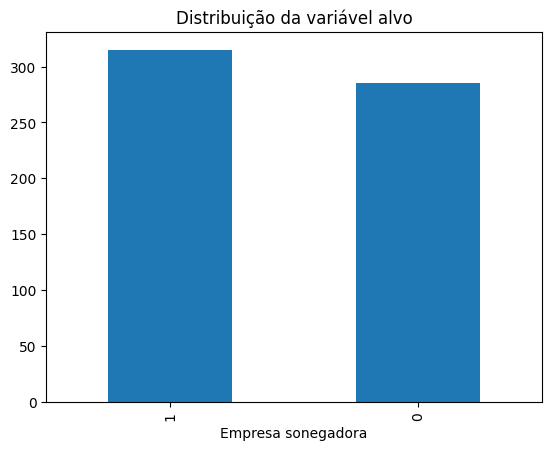

In [53]:
contagem = df_indicadores_de_risco['Sonegadora'].value_counts()

contagem.plot(kind= 'bar')
plt.title('Distribuição da variável alvo')
plt.xlabel('Empresa sonegadora')
plt.show()

A variável alvo está bem distribuída e com isso, encerramos a etapa de exploração dos dados. Compreendemos a estrutura dos dados cadastrais, comportamentos fiscais, indicadores de risco e a distribuição da variável de interesse. Agora, avançamos para o pré-processamento, etapa fundamental para garantir a robustez e qualidade do modelo preditivo.

### **Pré processamento**

Nesta etapa, realizei o tratamento necessário para tornar os dados compatíveis com o modelo linear de Regressão Logistica.

- Apliquei **codificação one-hot** para variáveis categóricas dos dataframes `dados_cadastrais` e `regularidade_fiscal`, transformando categorias em colunas booleanas.
- Em seguida, unifiquei os diferentes conjuntos de dados (`dados_cadastrais`, `comportamento_fiscal`, `regularidade_fiscal`, `indicadores de risco` e `variáveis derivadas`) em um único dataframe final.
- A chave de união utilizada foi o `CNPJ`.

Essas transformações preparam o conjunto para a etapa seguinte: **normalização e divisão entre variáveis preditoras e alvo**.

• Hot encoding para variáveis categóricas


In [54]:
# Hot encoding para os df Dados Cadastrais e Regularidade Fiscal.
# Respectivamente, nas colunas CNAE_principal e Regime_tributário, Situação_fiscal.
# O principal objetivo é transformar os dados categóricos em booleanos.

df_dados_cad_dummied = pd.get_dummies(df_dados_cadastrais, columns= ['CNAE_principal','Regime_tributário', 'Município'], dtype= int)  
df_reg_fiscal_dummied = pd.get_dummies(df_regularidade_fiscal, columns= ['Situação_fiscal'], dtype= int)

# Faz o hot encoding das respectivas colunas e ordena as colunas na seguinte lógica: 
# as que não sofreram o hotencoding vem primeiro, seguidas das que sofreram.

Antes de unificar os dataframes, a partir dos dados que foram coletados, é possível gerar algumas variáveis que irão auxiliar o modelo em sua tomada de decisão.

• Var: tempo_de_vida:
A primeira que podemos considerar é o tempo de vida da empresa. 
A hipotése é que, empresas com maior tempo de vida, geram mais receita e, devem gerar mais notas (se agirem de acordo com as leis) e consequentemente devem ter gasto mais com tributos. 

• Var: icms_faturamento:
Uma outra variável importante é quanto de ICMS uma determinada empresa pagou em relação ao que foi gerado pelo total das notas no mês.
Dessa forma é possível saber se a empresa está arcando com a carga tributária correspondente as notas emitidas.

• Var: faturamento_por_funcionario:
Além disso, para um determinado ramo, como por exemplo o de construção civil, altos lucros em detrimento de poucos funcionários pode acarretar em uma alta produtividade por parte dos funcionários o que levanta dúvidas.


In [55]:
# O tempo de vida da empresa pode ser calculado a partir de sua data de criação da seguinte forma:

df_dados_cad_dummied['Data_abertura'] = pd.to_datetime(df_dados_cad_dummied['Data_abertura']) # Converte os dados da coluna para datetime.
data_hoje = pd.Timestamp(date.today())
tempo_de_vida = [ (data_hoje - data_abertura).days // 365 for data_abertura in df_dados_cad_dummied['Data_abertura']]

# Cálculo do ICMS:
icms_faturamento = [a/b for a, b in zip(df_comportamento_fiscal['Valor_ICMS_pago_mensal'], df_comportamento_fiscal['Valor_total_notas_emitidas'])]

# Cálculo do faturamento por funcionário: 
faturamento_por_funcionario = [ round(a/b, 2) if b != 0 else 0 for a, b in zip(df_comportamento_fiscal['Valor_total_notas_emitidas'], df_dados_cad_dummied['Número_funcionários'])]

# Essas 3 métricas irão servir para aprimorar o raciocínio do modelo.

# Convertendo-as em um dataframe:
metricas_derivadas = pd.DataFrame({
    'CNPJ': [cnpj for cnpj in df_dados_cad_dummied['CNPJ']],
    'icms_faturamento': icms_faturamento,
    'tempo_de_vida': tempo_de_vida,
    'faturamento_por_funcionario': faturamento_por_funcionario
})

print(metricas_derivadas.head(5))


        CNPJ  icms_faturamento  tempo_de_vida  faturamento_por_funcionario
0  Empresa 1          0.062280              1                     23083.42
1  Empresa 2          0.051172              8                     15962.20
2  Empresa 3          0.035577              2                      9036.61
3  Empresa 4          0.030902              5                      7285.56
4  Empresa 5          0.013726              3                     13624.67


In [56]:
# Unindo os dataframes

# Lista dos df's que irão compor o df final.
lista_data_frames = [df_dados_cad_dummied, df_comportamento_fiscal, df_reg_fiscal_dummied, df_indicadores_de_risco, metricas_derivadas]

df_final = df_dados_cad_dummied

for df in lista_data_frames[1:]:
    df_final = df_final.merge(df, on = 'CNPJ')


• Normalização dos dados númericos para treinamento do modelo

Antes de realizar a normalização dos dados, é necessário entender o comportamento deles no espaço amostral, suas medidas, as diferenças entre os valores máximos e mínimos etc.
O estudo do histograma irá permitir selecionar a melhor técnica de normalização/scaler com objetivo de evitar outliers.

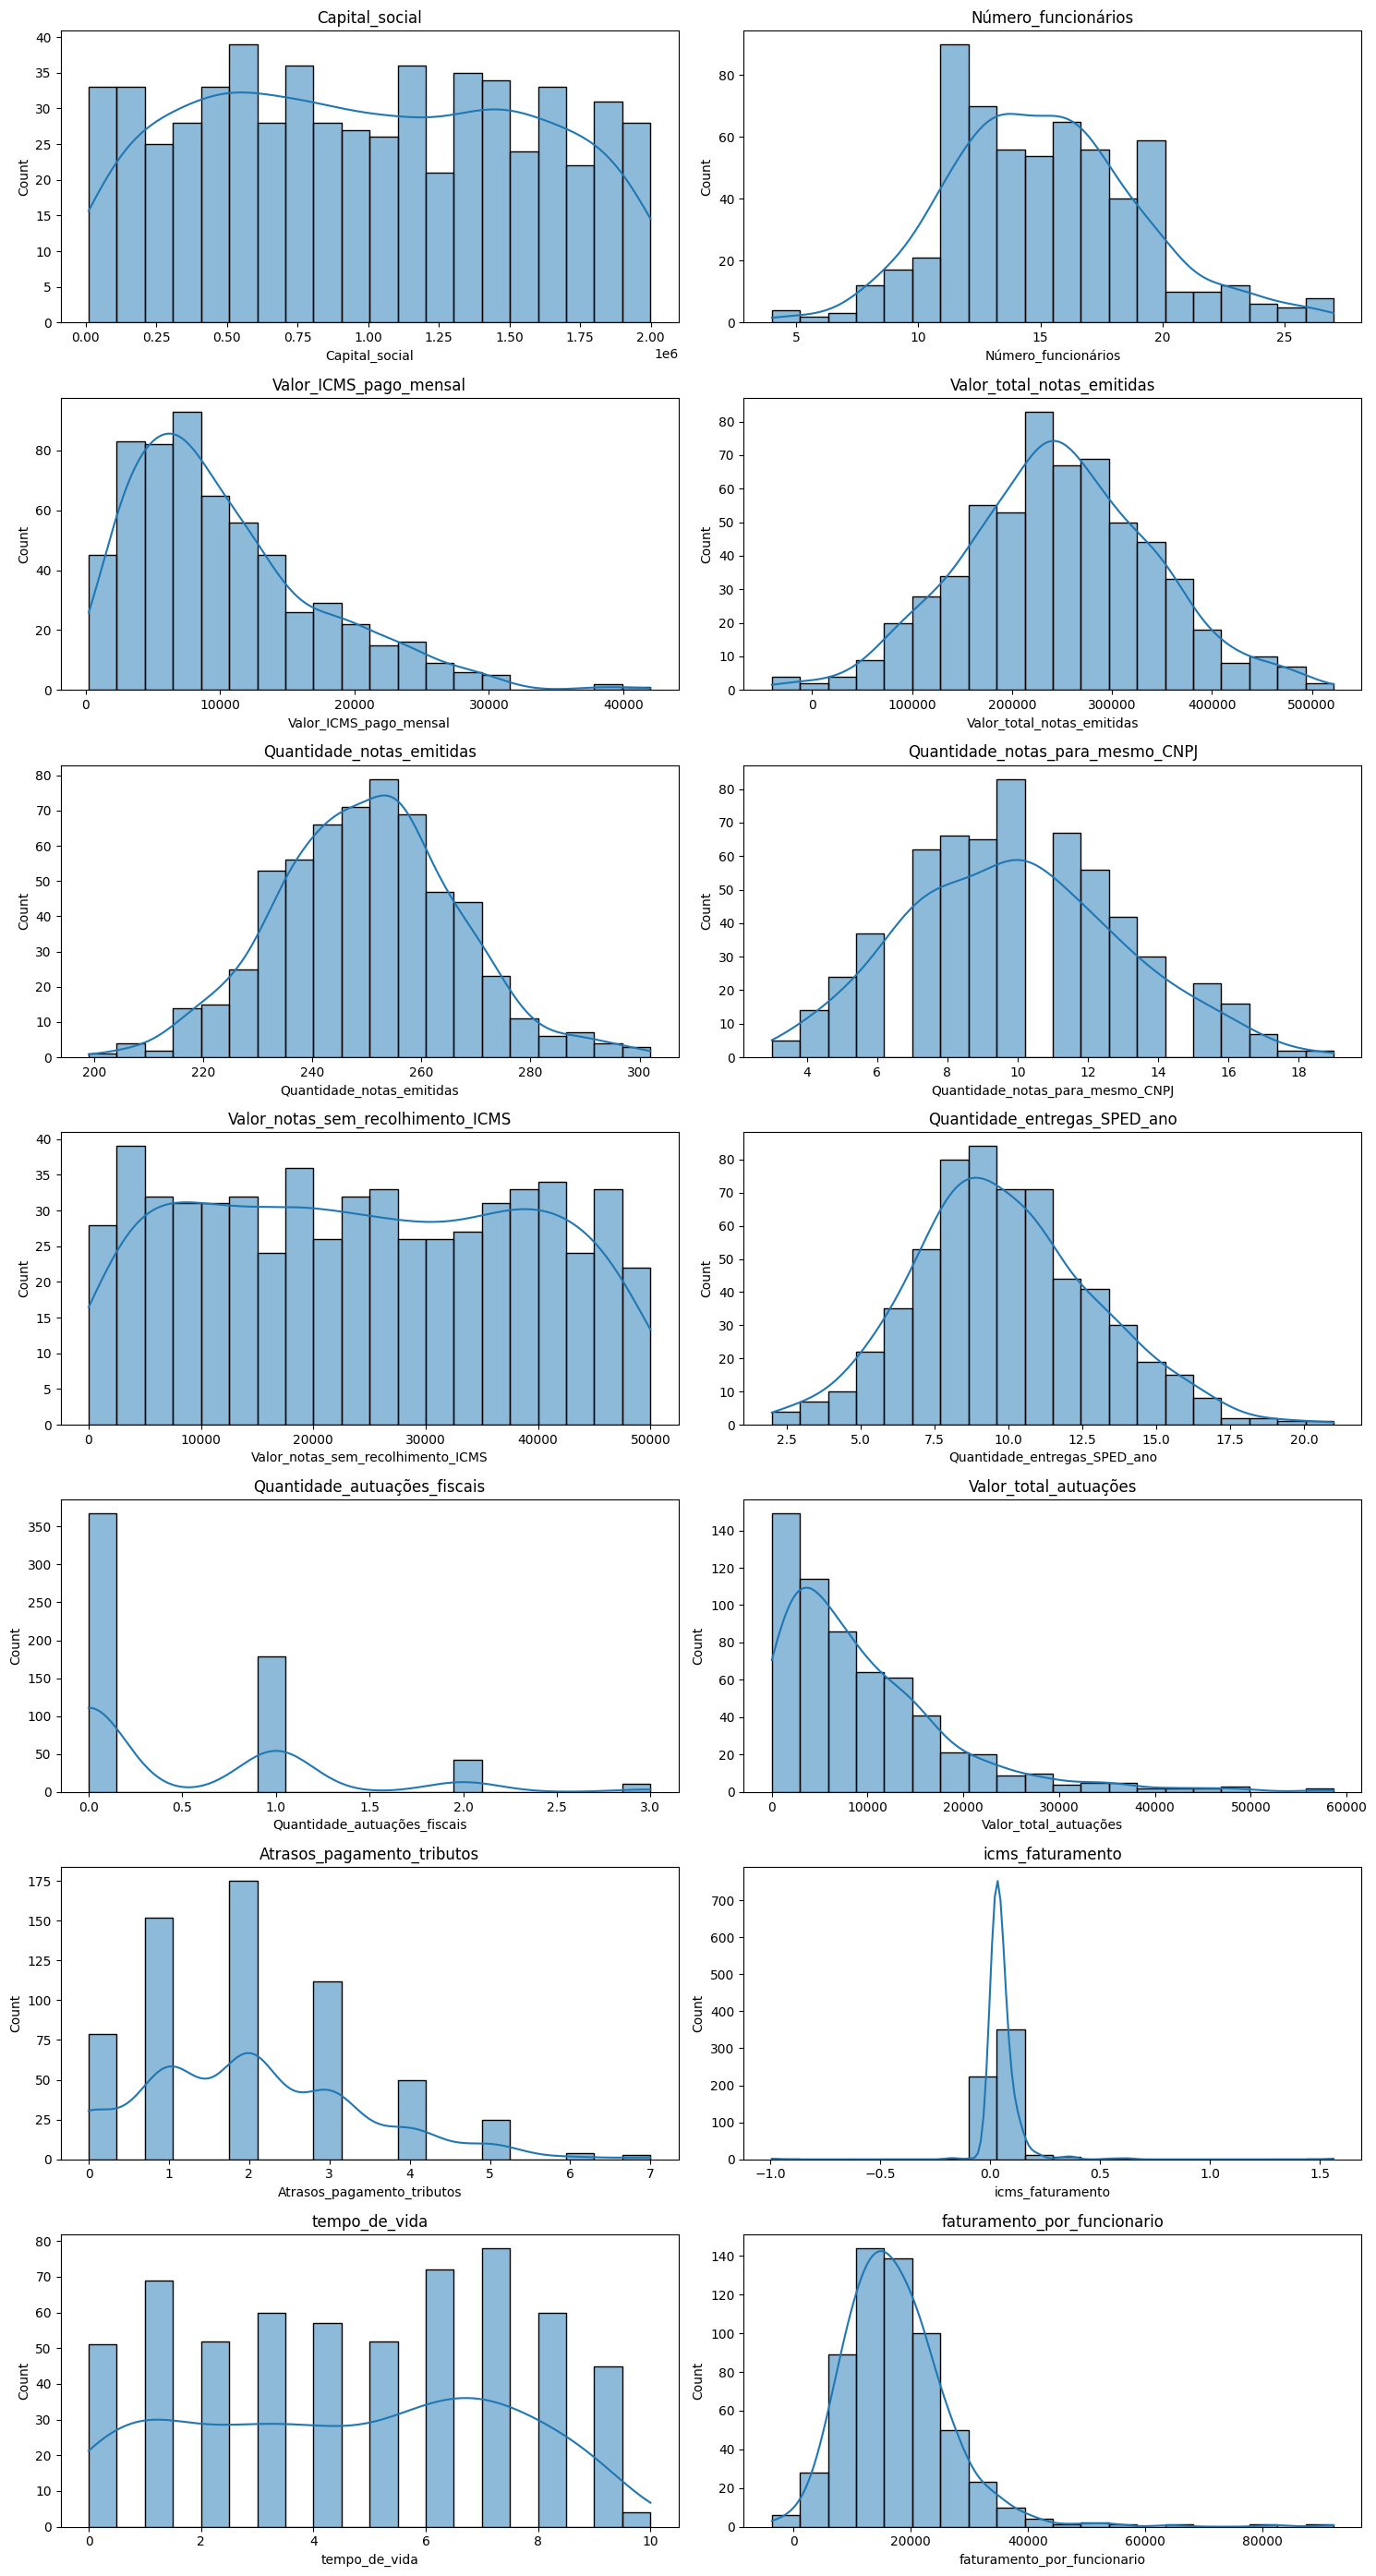

In [58]:
# Lista com o nome de todas as colunas que possuem valores numéricos contínuos que devem ser normalizados. 
colunas_normalizar = [
    'Capital_social', 'Número_funcionários',
    'Valor_ICMS_pago_mensal', 'Valor_total_notas_emitidas',
    'Quantidade_notas_emitidas', 'Quantidade_notas_para_mesmo_CNPJ',
    'Valor_notas_sem_recolhimento_ICMS',
    'Quantidade_entregas_SPED_ano', 'Quantidade_autuações_fiscais',
    'Valor_total_autuações', 'Atrasos_pagamento_tributos', 'icms_faturamento',
    'tempo_de_vida', 'faturamento_por_funcionario'
]

# Plotando os histogramas:

qtd_graficos = len(colunas_normalizar)

graficos_por_linha = 2

linhas = math.ceil( qtd_graficos/graficos_por_linha)  # math.ceil arredonda para cima a quantidade resultante da operação contida no argumento da função.

plt.figure(figsize=(15, linhas * 4))

for i, nome_coluna in enumerate(colunas_normalizar):    # Loop para plotar o histograma de cada uma das colunas contidas em 'colunas_normalizar'
    plt.subplot(linhas, graficos_por_linha, i+1)
    sns.histplot(df_final[nome_coluna], kde = True, bins = 20)   # O argumento kde ativa a função de linha de densidade suavizada, que basicamente é uma função representativa da continuidade dos dados nas classes.
    plt.title(nome_coluna)
    plt.tight_layout()

plt.show()

A partir dos histogramas plotados, nota-se que há algumas colunas que possuem valores que distoam muito ao mesmo tempo em que possuem curvas de densidade acentuadas (caudas longas).
Como exemplo: quantidade_de_notas_emitidas, valor_total_notas_emitidas e valor_total_autuações.
Dessa forma, utilizar a função RobustScaler mostra-se a melhor alternativa para tratamento e normalização desses outliers.  

In [59]:
# Normalizando as colunas:

# Instancia o objeto RobustScaler
# O RobustScaler normaliza os dados com base na mediana e no intervalo interquartílico (IQR)
sc_robust = RobustScaler()

df_final[colunas_normalizar] = sc_robust.fit_transform(df_final[colunas_normalizar])


### **Separação entre variáveis preditoras e alvos**

A variável-alvo do projeto é `Sonegadora`, representando se uma empresa sonega impostos (1) ou não (0).

Removemi os campos `CNPJ` e `Data_abertura` por se tratarem de identificadores diretos, que não devem ser utilizados como preditores.

Além disso, criei **dois conjuntos distintos de variáveis preditoras**:
- `x_com_autuacoes`: inclui todas as variáveis, inclusive `Quantidade_autuações_fiscais`.
- `x_sem_autuacoes`: remove essa variável por se tratar de uma informação que **pode refletir diretamente a variável-alvo** (uma vez que autuação já é consequência da sonegação).

Essa estratégia nos permitirá avaliar se o modelo se tornaria **enviesado** ao utilizar uma variável que pode carregar uma relação circular com o alvo.

Diversos são os motivos que levam empresas a sonegarem o pagamento dos tributos advindos de suas atuações. No Brasil, grande parte das empresas possuem esse 
comportamento com o objetivo de se manterem competitivas no mercado, uma vez que a concorrência, para manter os preços baixos, sonega o pagamento do tributo.
Outra motivação é o aumento da receita uma vez que o poder de compra da moeda brasileira é muito baixo.
Nesse cenário, as principais práticas utilizadas pelas empresas para sonegarem impostos tem sido:
- Omissão de receitas: a empresa opta por não realizar todas as suas vendas/movimentações.
- Emissão de notas frias: notas fiscais com valores adulterados para baixa taxação.
- Venda sem nota fiscal: evitar o pagamento de impostos.
- Sonegação previdenciária: deixa de registrar funcionários.
- Subfaturamento: Declara um valor de venda menor que o real. 

Antes de treinar o modelo, é essencial compreender quais variáveis possuem maior correlação com a variável-alvo. Utilizamos aqui o coeficiente de correlação Point-Biserial, indicado para relacionar variáveis contínuas com variáveis binárias.


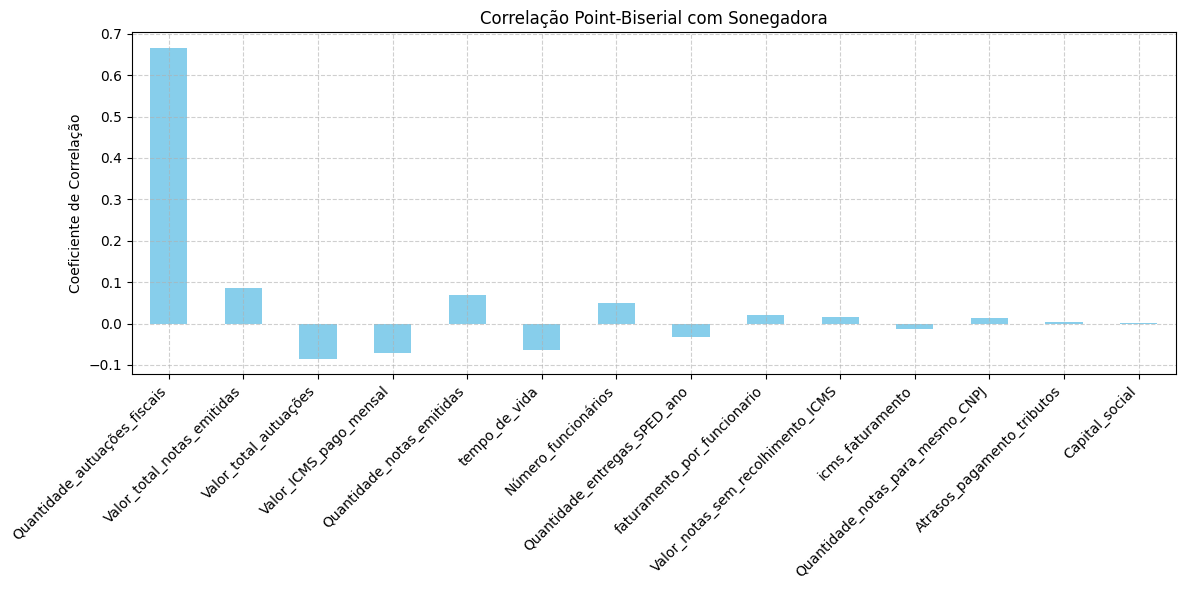

In [60]:
# Dessa forma, a partir do contexto acima e dos dados dispostos no dataset, podemos verificar quais são as variáveis numéricas continuas que mais possuem correlação com o nosso alvo (empresa ser sonegadora).
# Para isso, iremos utilizar uma função estatística chamada de Point-Biserial que analisa a correlação entre variáveis númericas e o alvo binários.


# Lista de colunas contínuas normalizadas
colunas_normalizadas = [
    'Capital_social', 'Número_funcionários',
    'Valor_ICMS_pago_mensal', 'Valor_total_notas_emitidas',
    'Quantidade_notas_emitidas', 'Quantidade_notas_para_mesmo_CNPJ',
    'Valor_notas_sem_recolhimento_ICMS',
    'Quantidade_entregas_SPED_ano', 'Quantidade_autuações_fiscais',
    'Valor_total_autuações', 'Atrasos_pagamento_tributos',
    'icms_faturamento', 'tempo_de_vida', 'faturamento_por_funcionario'
]

# Calcular correlação de Point-Biserial com a variável Sonegadora
correlacoes_pb = {}
for coluna in colunas_normalizadas:
    correlacao, p_valor = pointbiserialr(df_final[coluna], df_final['Sonegadora'])   # Nessa linha é passado o valor da coeficiente da correlação e o valor do teste estatístico encontrado
    correlacoes_pb[coluna] = correlacao

# Converter em Series e ordenar
correlacoes_series = pd.Series(correlacoes_pb).sort_values(key=abs, ascending=False)

# Plotar gráfico de barras
plt.figure(figsize=(12, 6))
correlacoes_series.plot(kind='bar', color='skyblue')
plt.title('Correlação Point-Biserial com Sonegadora')
plt.ylabel('Coeficiente de Correlação')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

A partir do cálculo da correlação dos dados númericos com o alvo, foi gerado o coeficiente de correlação que nos mostra quais colunas correlacionam de forma positiva com a variável alvo. Ou seja,
para os valores positivos (> 0), a correlação tendencia que a empresa seja sonegadora, enquanto para os valores negativos (< 0), a correlação é de que não sejam. 
Ambas as correlações contribuem para o treinamento do modelo.

Nota-se que a variável quantidade_autuações_fiscais possui uma correlação muito forte em comparação com as outras. Isso acaba sendo um problema pois pode enviesar o modelo durante o seu treinamento, de forma que quanto dependendo da quantidade de autuações ele pode classifica-la como sonegadora. Para isso iremos treinar 2 modelos distintos com o objetivo de validar a capacidade dele de generalizar, com e sem a variável. Para isso, será setado 2 variáveis X(preditoras) de treino.

In [61]:
# Variável com autuações
x_com_autuacoes = df_final.drop(columns = ['Sonegadora', 'CNPJ', 'Data_abertura'])

# Variável sem autuações
x_sem_autuacoes = x_com_autuacoes.drop(columns = ['Quantidade_autuações_fiscais'])

# Variável alvo
y = df_final['Sonegadora']

### **Escolha e justificativa do modelo**

Neste projeto, optei por utilizar a **Regressão Logística** como modelo central para prever a probabilidade de uma empresa incorrer em sonegação fiscal. Essa escolha foi fundamentada em critérios técnicos e estratégicos:

- **Natureza binária da variável alvo**, o que se alinha diretamente ao funcionamento da regressão logística.
- **Alta interpretabilidade**, permitindo compreender como cada variável influencia o risco de sonegação.
- **Eficiência computacional**, favorecendo testes rápidos e reprodutibilidade.
- **Simplicidade e robustez**, sobretudo com as variáveis já normalizadas e tratadas adequadamente no pré-processamento.
- **Alinhamento com o objetivo do projeto**, que é entregar uma solução funcional, clara e explicável.

### **Treinando o modelo**

Confore analisado previamente, a variável `Quantidade_autuações_fiscais` pode enviesar o modelo. Por conta disso, será treinado 2 modelos diferentes em que um possui a variável e o outro não.
Dessa forma será possível analisar o comportamento do modelo para ambos os casos e validar a hipótese.

• Treinando o modelo sem a variável Quantidade_autuações_fiscal

In [62]:
# Realiza a separação dos dados de treino e teste para o Modelo 1 (com autuação)
X_train1, X_test1, y_train, y_test = train_test_split(
    x_com_autuacoes, y, test_size=0.3, random_state=42, stratify=y)

# Instância o modelo com o máximo de iterações sendo 1000x.
modelo_com_autuacoes = LogisticRegression(max_iter=1000)
modelo_com_autuacoes.fit(X_train1, y_train) # Atribui os pesos do modelo conforme os dados de treinamento

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


• Treinando o modelo com a variável Quantidade_autuações_fiscal

In [63]:
# Realiza a separação dos dados de treino e teste para o Modelo 2 (sem autuação)
X_train2, X_test2 = train_test_split(
    x_sem_autuacoes, test_size=0.3, random_state=42, stratify=y)[0:2]

# Instância o modelo com o máximo de iterações sendo 1000x.
modelo_sem_autuacoes = LogisticRegression(max_iter=1000)
modelo_sem_autuacoes.fit(X_train2, y_train)  # Atribui os pesos do modelo conforme os dados de treinamento

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### **Testando e avaliando o modelo**

Ambos os modelos foram avaliados quanto à sua capacidade de prever corretamente empresas sonegadoras e não sonegadoras. Utilizei métricas amplamente adotadas em classificadores binários:

- **Acurácia**: Proporção total de acertos.
- **Precisão**: Das empresas previstas como sonegadoras, quantas realmente eram.
- **Recall (Sensibilidade)**: Das empresas que realmente sonegam, quantas foram identificadas.
- **F1-score**: Média harmônica entre precisão e recall.
- **AUC-ROC**: Capacidade do modelo de separar positivamente as classes.

• Modelo com a variável autuações fiscal.

In [64]:
# Modelo 1 - com a variável 'Quantidade_autuações_fiscais'
y_pred1 = modelo_com_autuacoes.predict(X_test1)
y_prob1 = modelo_com_autuacoes.predict_proba(X_test1)[:, 1]     # Probabilidades de ser uma empresa sonegadora.

# Métricas do modelo 1.
print("Modelo com autuações:")
print("Acurácia:", round(accuracy_score(y_test, y_pred1),2))    # Proporção dos acertos do modelo (positivos e negativos) sobre o total.
print("Precisão:", round(precision_score(y_test, y_pred1),2))   # Precisão das empresas que o modelo previu como sonegadora, quantos são
print("Recall:", round(recall_score(y_test, y_pred1),2))        # Das empresas que realmente sonegam, quantas foram detectadas.
print("F1-score:", round(f1_score(y_test, y_pred1),2))          # Média harmônica
print("AUC-ROC:", round(roc_auc_score(y_test, y_prob1),2))      # Mede a probabilidade de o modelo rankear corretamente uma instância (positiva ou negativa).

Modelo com autuações:
Acurácia: 0.92
Precisão: 0.95
Recall: 0.88
F1-score: 0.92
AUC-ROC: 0.96


• Modelo sem a variável autuações fiscal.

In [65]:
# Modelo 2 - sem a variável 'Quantidade_autuações_fiscais'
y_pred2 = modelo_sem_autuacoes.predict(X_test2)
y_prob2 = modelo_sem_autuacoes.predict_proba(X_test2)[:, 1]     

# Métricas para o modelo sem autuações
print("\nModelo sem autuações:")
print("Acurácia:", round(accuracy_score(y_test, y_pred2),2))
print("Precisão:", round(precision_score(y_test, y_pred2),2))
print("Recall:", round(recall_score(y_test, y_pred2),2))
print("F1-score:", round(f1_score(y_test, y_pred2),2))
print("AUC-ROC:", round(roc_auc_score(y_test, y_prob2),2))


Modelo sem autuações:
Acurácia: 0.56
Precisão: 0.57
Recall: 0.62
F1-score: 0.59
AUC-ROC: 0.62


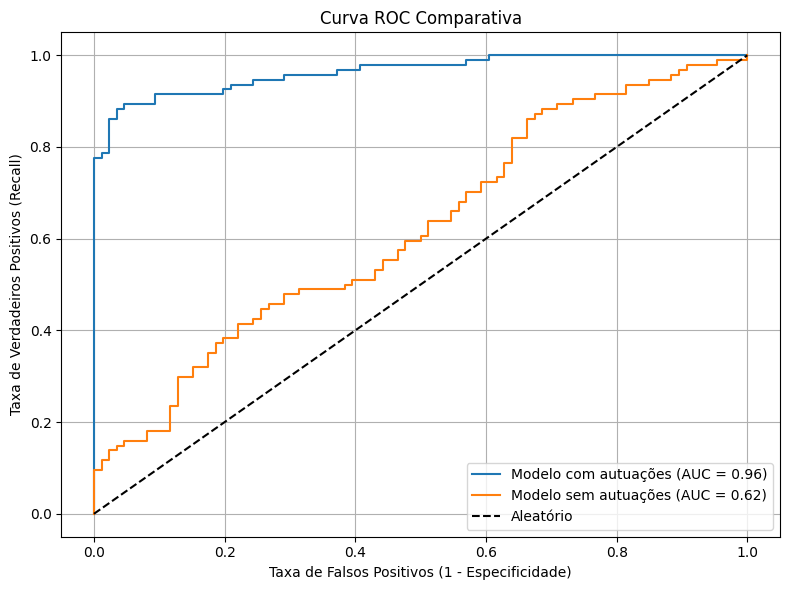

In [66]:
# Calcula as curvas ROC
fpr1, tpr1, _ = roc_curve(y_test, y_prob1)
fpr2, tpr2, _ = roc_curve(y_test, y_prob2)

# Plota as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label='Modelo com autuações (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob1)))
plt.plot(fpr2, tpr2, label='Modelo sem autuações (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob2)))
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

plt.title('Curva ROC Comparativa')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

A partir do gráfico da curva ROC é possível identificar que a variável Quantidade_autuações_fiscais tem um impacto significativo na acurácia dos resultados quando em comparação com o modelo treinado sem a variável. Isso indica que para futuros modelos, explorar mais o contexto de autuações pode trazer resultados ainda mais expressivos.


### **Conclusões dos desempenhos dos modelos.**



• Plotando o gráfico comparativo entre os 2 modelos.

<Figure size 1000x600 with 0 Axes>

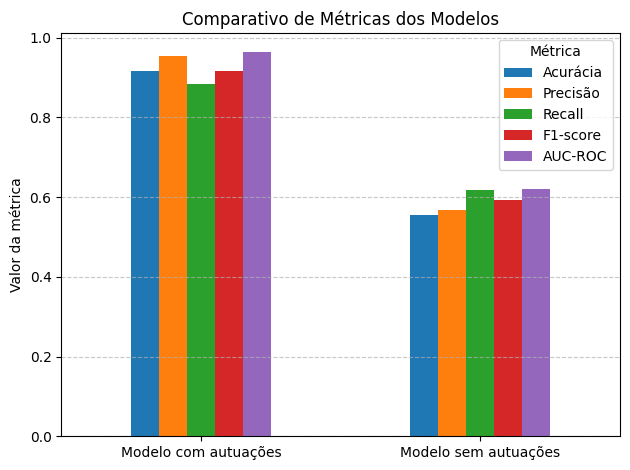

In [67]:
#Dicionário com as métricas para plotagem dos gráficos.
metricas = {
    "Modelo com autuações": {
        "Acurácia": accuracy_score(y_test, y_pred1),
        "Precisão": precision_score(y_test, y_pred1),
        "Recall": recall_score(y_test, y_pred1),
        "F1-score": f1_score(y_test, y_pred1),
        "AUC-ROC": roc_auc_score(y_test, y_prob1)
    },
    "Modelo sem autuações": {
        "Acurácia": accuracy_score(y_test, y_pred2),
        "Precisão": precision_score(y_test, y_pred2),
        "Recall": recall_score(y_test, y_pred2),
        "F1-score": f1_score(y_test, y_pred2),
        "AUC-ROC": roc_auc_score(y_test, y_prob2)
    }
}

df_metricas = pd.DataFrame(metricas).T   # Converte em um dataframe transposto. 

# Plot do gráfico comparativo
plt.figure(figsize=(10, 6))
df_metricas.plot(kind='bar')
plt.title("Comparativo de Métricas dos Modelos")
plt.ylabel("Valor da métrica")
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Conclusão 1**: 
A partir do gráfico plotado acima podemos inferir que a variável 'Quantidade_autuações_fiscais' de fato corrobora de maneira significativa na determinação do modelo. No entanto, ainda devemos verificar, após o treinamento, quais variáveis mais colaboraram com a tomada de decisão do modelo.

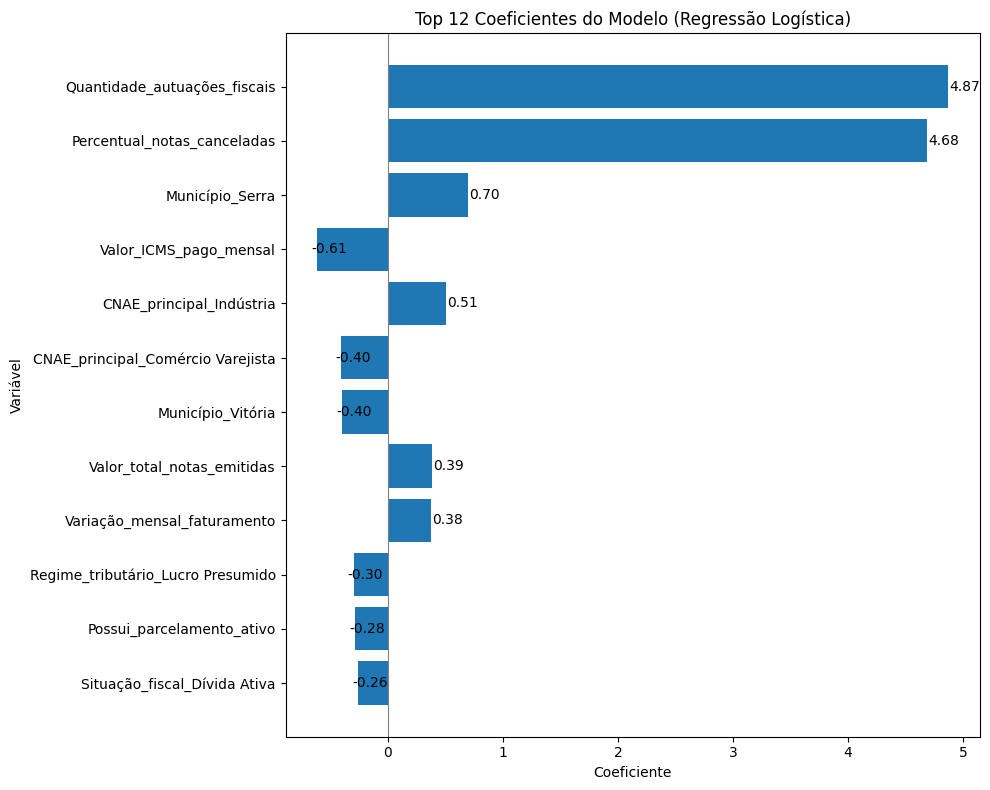

In [68]:
# Nomes das colunas usadas no modelo com autuações
nomes_colunas = X_train1.columns

# Coeficientes do modelo
coeficientes = modelo_com_autuacoes.coef_[0]

# Dataframe com os nomes e coeficientes
df_coef = pd.DataFrame({
    'Variável': nomes_colunas,
    'Coeficiente': coeficientes
})

# Ordenar por magnitude (absoluto do coeficiente)
df_coef['Importância Absoluta'] = df_coef['Coeficiente'].abs()
df_coef_ordenado = df_coef.sort_values(by='Importância Absoluta', ascending=False)

import matplotlib.pyplot as plt

# 10 principais coeficientes
var_influentes = 12
plt.figure(figsize=(10, 8))
barras = plt.barh(df_coef_ordenado['Variável'][:var_influentes][::-1], df_coef_ordenado['Coeficiente'][:var_influentes][::-1])
plt.axvline(0, color='gray', linewidth=0.8)
plt.title(f'Top {var_influentes} Coeficientes do Modelo (Regressão Logística)')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')

# Adicionar os valores no final de cada barra
for bar in barras:
    width = bar.get_width()
    x_pos = width + 0.01 if width >= 0 else width - 0.05
    plt.text(x_pos, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()

**Conclusão 2:** A principal justificativa para dizer que o modelo não foi enviesado e pelo fato de haver uma outra variável (notas canceladas) que possuiu uma maior relevância para a detecção de empresas sonegadoras. Além disso, nota-se que houve outras variáveis que tiveram impacto significativo no treinamento do modelo, sendo uma delas, uma variável que classifica empresas não sonegadoras. Validando as tomadas de decisão do modelo foram multifatorais sem que nenhum viés oculto interferisse. 

**Classificar uma empresa como sendo sonegadora, ou até mesmo deixar passar uma empresa que é sonegadora continuar atuando de forma legal podem gerar problemas sérios para o estado. Dessa forma, avaliar o quantitativo de Falsos Positivos (FP) e Falsos Negativos (FN) é uma tarefa importante para validar se o modelo de fato esta sendo eficiente em seu objetivo.**

Para isso, calcular a Matriz de Confusão é importante para melhor visualizar essa acurácia.

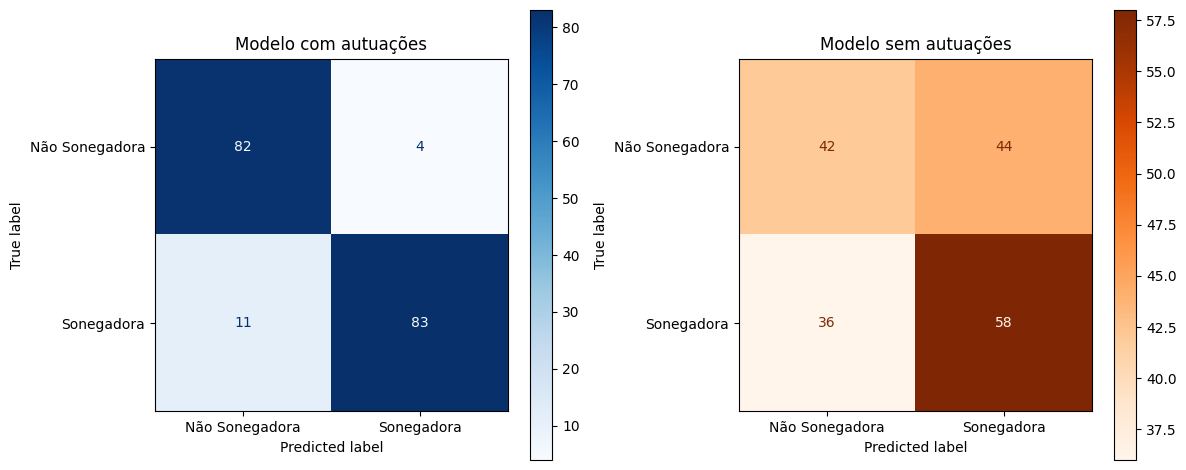

In [69]:
# Gera matrizes de confusão
cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)

# Exibir as matrizes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Modelo com autuações
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["Não Sonegadora", "Sonegadora"])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Modelo com autuações")

# Modelo sem autuações
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Não Sonegadora", "Sonegadora"])
disp2.plot(ax=axes[1], cmap='Oranges', values_format='d')
axes[1].set_title("Modelo sem autuações")



plt.tight_layout()
plt.show()

**Conclusão:** A partir da matriz plotada, nota-se que o modelo que utiliza a variável de `Quantidade_autuações_fiscais` teve uma boa acurácia em relação ao outro modelo. Apesar disso, também podemos concluir que a ferramenta deve, obrigatoriamente, ser utilizada por um especialista para evitar possíveis falsas acusações para os dois cenários.
 

## **Conclusão Final**

Este estudo demonstrou que, embora seja possível aplicar técnicas de machine learning para análise fiscal, os resultados obtidos apontam limitações importantes em termos de desempenho do modelo. Fatores como complexidade da variável alvo, qualidade dos dados e limitações nos atributos utilizados influenciaram diretamente na capacidade preditiva. Mesmo com ajustes, o modelo apresentou dificuldades em separar corretamente as classes. Isso evidencia a necessidade de:

- Dados mais ricos e específicos;

- Teste com modelos não lineares;

- Avaliações mais robustas com variáveis temporais e auditorias fiscais reais;

O estudo, portanto, serve como ponto de partida para futuras iterações com maior potencial preditivo. Apesar disso, vale a pena ressaltar que tais práticas apenas servem como ferramentas de auxílio por parte de especialistas no dia a dia.